# Notebook 1: Data Cleaning & Greeks

In this notebook, we transform raw SPY option chain data (downloaded from Yahoo Finance) into a **clean, analysis-ready dataset**.

We will:
- Standardize option quotes (mid-prices and bid-ask spreads),
- Compute **time-to-expiry (τ)** and **moneyness** (strike/spot),
- Add **Black–Scholes Greeks** (Δ, Γ, Vega, Θ),
- Save the results for downstream analysis (IV surface, SVD, ML).

This step is essential: messy option chains include stale quotes, illiquid contracts, and inconsistent pricing. Cleaning ensures we only use **tradeable, meaningful contracts** in our model.

## 1. Setup & Imports

We import standard Python libraries for data analysis (pandas, numpy) and mathematical tools (scipy for probability distributions). We don’t set file paths here because we’ll directly reference the raw data files when loading them.

In [35]:
import sys, os
import pandas as pd
import numpy as np
from datetime import datetime
from math import log, sqrt, exp
from scipy.stats import norm
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))
from src.utils import bs_greeks

## 2. Load Raw Data

We start by loading the raw SPY option chain and the underlying SPY price history.

- `SPY_options.csv` contains strikes, expiries, bid/ask quotes, implied volatilities, and volumes.
- `SPY_prices.csv` contains the underlying ETF's daily close price, which we need for computing moneyness.

We inspect the first rows to confirm the structure and the number of contracts.

In [36]:
import glob

# Load all option snapshots
option_files = glob.glob("../data/raw/SPY_options_*.csv")
options = pd.concat([pd.read_csv(f) for f in option_files], ignore_index=True)

# Load all price snapshots
price_files = glob.glob("../data/raw/SPY_prices_*.csv")
prices = pd.concat([pd.read_csv(f) for f in price_files], ignore_index=True)

print("Options shape:", options.shape)
print("Prices shape:", prices.shape)

Options shape: (2410, 17)
Prices shape: (500, 9)


## 3. Basic Cleaning

Raw option quotes often contain bad or untradeable rows. We fix this by:

- **Mid-price**: Use `(bid + ask)/2` instead of last trade to reduce noise.  
- **Spread**: `(ask - bid)/mid` measures liquidity; wide spreads mean unrealistic prices.  
- **Filters**:
  - Drop contracts with `volume=0` and `openInterest=0` (nobody is trading them).  
  - Drop contracts with `mid <= 0` (stale).  
  - Drop contracts with `spread > 20%` (too illiquid).  

This leaves us with realistic, liquid options we could actually trade.

In [37]:
options["mid"] = (options["bid"] + options["ask"]) / 2
options["spread"] = (options["ask"] - options["bid"]) / options["mid"].replace(0, np.nan)

clean = options.copy()
clean = clean[clean["mid"] > 0]
clean = clean[(clean["volume"].fillna(0) > 0) | (clean["openInterest"].fillna(0) > 0)]
clean = clean[clean["spread"] < 0.2]

print("Remaining rows after cleaning:", len(clean))
clean.head()

Remaining rows after cleaning: 1574


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,expiry,download_date,mid,spread
1,SPY250916C00570000,2025-09-12 14:27:10+00:00,570.0,91.30,89.04,91.84,3.400002,3.868033,31.0,32.0,1.647463,True,REGULAR,USD,C,2025-09-16,2025-09-15,90.44,0.030960
2,SPY250916C00580000,2025-09-12 15:16:14+00:00,580.0,78.29,79.04,81.84,0.000000,0.000000,NaN,1.0,1.487307,True,REGULAR,USD,C,2025-09-16,2025-09-15,80.44,0.034809
3,SPY250916C00585000,2025-09-04 14:49:44+00:00,585.0,75.74,74.05,76.85,14.019997,22.715483,2.0,1.0,1.410159,True,REGULAR,USD,C,2025-09-16,2025-09-15,75.45,0.037111
4,SPY250916C00590000,2025-09-15 17:35:47+00:00,590.0,70.27,69.05,71.83,8.219997,13.247377,1.0,1.0,1.324222,True,REGULAR,USD,C,2025-09-16,2025-09-15,70.44,0.039466
5,SPY250916C00600000,2025-09-15 20:09:58+00:00,600.0,60.57,59.05,61.83,11.200001,22.685844,320.0,10.0,1.164067,True,REGULAR,USD,C,2025-09-16,2025-09-15,60.44,0.045996


## 4. Add τ (time-to-expiry) and Moneyness

Options with the same expiry date or strike are not directly comparable. We need normalized variables:

- **Time-to-expiry (τ):**  
  `(expiry_date – trade_date) / 365`  
  Converts expiry into a continuous measure in years.  

- **Moneyness:**  
  `strike / spot`  
  Shows how far the strike is from the current price (ATM ≈ 1, ITM < 1 for calls, > 1 for puts).  

These quantities make contracts across strikes and expiries comparable. They are also the natural coordinates for volatility surfaces.

In [38]:
clean["download_date"] = pd.to_datetime(clean["download_date"])
clean["expiry"] = pd.to_datetime(clean["expiry"])
clean["tau"] = (clean["expiry"] - clean["download_date"]).dt.days / 365

spot = prices["Close"].iloc[-1]  # latest SPY close
clean["moneyness"] = clean["strike"] / spot


## 5. Compute Greeks (from Black–Scholes model)

The **Black–Scholes formula** for a European call option is:

$$ C = S_0 N(d_1) - K e^{-r\tau} N(d_2) $$

and for a European put:

$$ P = K e^{-r\tau} N(-d_2) - S_0 N(-d_1) $$

with:

$$ d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \tfrac{1}{2}\sigma^2\right)\tau}{\sigma \sqrt{\tau}}, \qquad
d_2 = d_1 - \sigma \sqrt{\tau} $$

---

### Greeks

- **Delta (Δ):**

$$ \Delta_{call} = N(d_1), \qquad \Delta_{put} = N(d_1) - 1 $$

- **Gamma (Γ):**

$$ \Gamma = \frac{N'(d_1)}{S_0 \, \sigma \sqrt{\tau}} $$

- **Vega:**

$$ \text{Vega} = S_0 N'(d_1)\sqrt{\tau} $$

- **Theta (Θ):**

Call option:

$$ \Theta_{call} = -\frac{S_0 N'(d_1)\sigma}{2\sqrt{\tau}} - rK e^{-r\tau} N(d_2) $$

Put option:

$$ \Theta_{put} = -\frac{S_0 N'(d_1)\sigma}{2\sqrt{\tau}} + rK e^{-r\tau} N(-d_2) $$

---

- $S_0$: underlying price  
- $K$: strike price  
- $r$: risk-free rate  
- $\tau$: time-to-expiry (years)  
- $\sigma$: implied volatility  
- $N(\cdot)$: cumulative normal distribution  
- $N'(\cdot)$: standard normal density function  

In this project, $\sigma$ comes directly from the **implied volatility** quoted in the option chain. These Greeks are then computed by plugging $\sigma$ into the Black–Scholes model, ensuring they reflect the market’s pricing.


In [39]:
r = 0.05  # assume 5% risk-free rate

greeks = clean.apply(
    lambda row: bs_greeks(spot, row["strike"], row["tau"], r, row["impliedVolatility"], row["type"]),
    axis=1
)

clean[["delta","gamma","vega","theta"]] = pd.DataFrame(greeks.tolist(), index=clean.index)


## 6. Save Cleaned Dataset

We save the final dataset with:

- Standardized option prices (mid, spread),
- Normalized variables (τ, moneyness),
- Risk sensitivities (Δ, Γ, Vega, Θ).

This artifact is stored as a Parquet file (`options_clean.parquet`) for efficient downstream use in IV surface construction and machine learning.

In [40]:
ARTIFACTS_DIR = os.path.join("..", "data", "artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

out_path = os.path.join(ARTIFACTS_DIR, "options_clean.parquet")
clean.to_parquet(out_path, index=False)
print(f"[OK] Saved cleaned file → {out_path}, rows: {len(clean)}")

[OK] Saved cleaned file → ../data/artifacts/options_clean.parquet, rows: 1574


## 7. Quick Visual Checks

Finally, we visualize to confirm our computations:

- **Histogram of IV** should show reasonable values (SPY often ~10–40%, higher in stress).
- **Δ vs Moneyness scatter** should follow the familiar S-shape:  
  - Δ ≈ 0 for deep OTM calls,  
  - Δ ≈ 1 for deep ITM calls,  
  - Δ ≈ 0.5 near ATM.

These checks validate that our Black–Scholes computations are consistent with financial intuition.

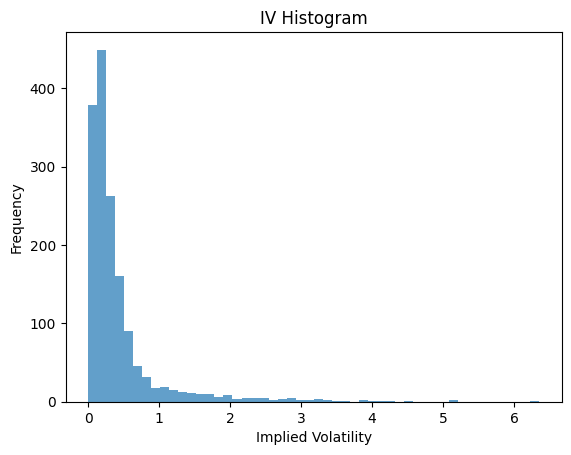

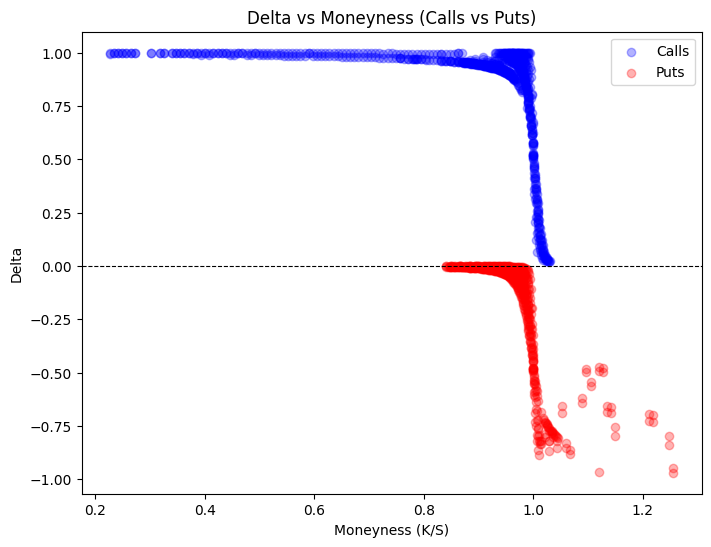

In [41]:
# Plot IV Histogram
plt.hist(clean["impliedVolatility"], bins=50, alpha=0.7)
plt.xlabel("Implied Volatility")
plt.ylabel("Frequency")
plt.title("IV Histogram")
plt.show()

# Separate calls and puts
calls = clean[clean["type"] == "C"]
puts = clean[clean["type"] == "P"]

plt.figure(figsize=(8,6))

# Plot calls in blue
plt.scatter(calls["moneyness"], calls["delta"], alpha=0.3, label="Calls", color="blue")

# Plot puts in red
plt.scatter(puts["moneyness"], puts["delta"], alpha=0.3, label="Puts", color="red")

plt.axhline(0, color="black", linewidth=0.8, linestyle="--")  # reference line
plt.xlabel("Moneyness (K/S)")
plt.ylabel("Delta")
plt.title("Delta vs Moneyness (Calls vs Puts)")
plt.legend()
plt.show()


# Outputs from Notebook 1
- Cleaned dataset: `options_clean.parquet`  
- Key columns: mid, spread, tau, moneyness, delta, gamma, vega, theta  
- Plots: IV histogram, Δ vs moneyness scatter  

This artifact is the foundation for:
- **Notebook 2:** Building IV surfaces and extracting SVD factors  
- **Notebook 3:** Feature engineering + ML model training  
- **Notebook 4:** Backtesting a delta-hedged trading strategy  